# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [ ]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    # Устанавливаем seed для NumPy
    np.random.seed(seed)

    # Устанавливаем seed для Python random
    random.seed(seed)

    # Устанавливаем seed для PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Вызываем функцию для установки seed
seed_everything(42)

Выпишем все классы для последующего использования.

In [ ]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "1ef5c169c752eb7e4ad56b533913fdd18931bfea"# вписать свой API Wandb
  project = "BDZ4"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "mabelin89"# ввести свой логин
  num_epochs = 20 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  wandb = False # флаг использования Wandb


In [ ]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [ ]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя
mean = 0.2859;  std = 0.3530
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                                ])


Загружаем данные.

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# Создаем загрузчики данных
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=CFG.train_batch_size, shuffle=True, num_workers=CFG.num_workers)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=CFG.test_batch_size, shuffle=False, num_workers=CFG.num_workers)

100%|██████████| 26421880/26421880 [00:02<00:00, 12651182.35it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210644.06it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3741598.76it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5425195.22it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples) # итерируемся по тестовым данным

In [ ]:
example_data.shape # проверим размерность

torch.Size([512, 1, 28, 28])

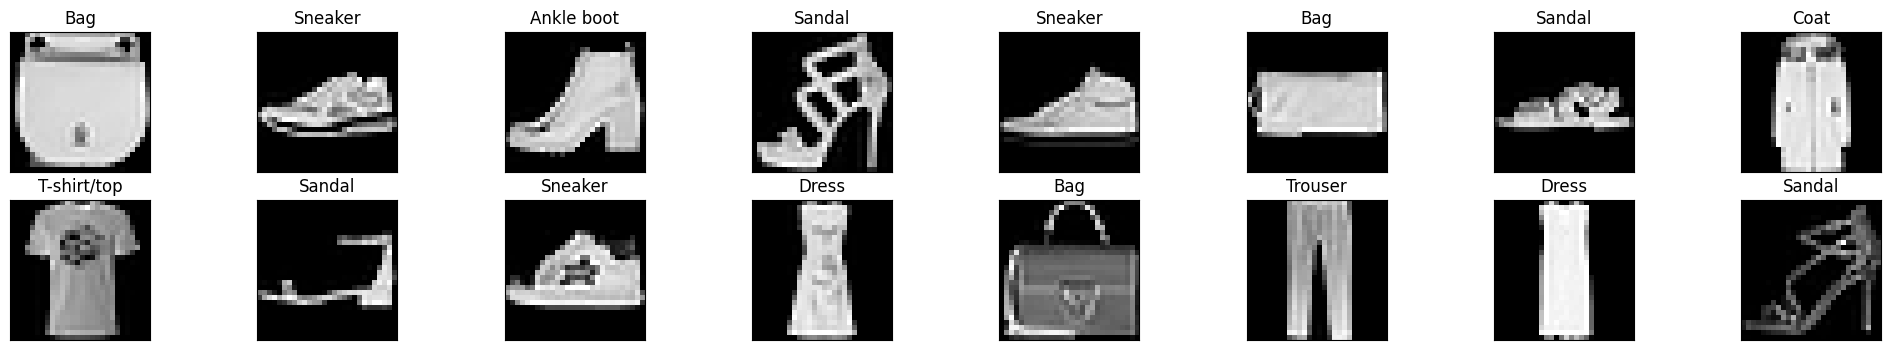

In [ ]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(CFG.classes[labels[idx]])

Создаем полносвязаннную нейронную сеть.

In [ ]:
class My_Net(nn.Module):
    def __init__(self):
        super(My_Net, self).__init__()

        # Количество нейронов в скрытых слоях (128, 64)
        hidden_1 = 128
        hidden_2 = 64

        # Первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # Второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # Нормализация данных
        self.norm_ = nn.BatchNorm1d(hidden_2)
        # Третий (выходной) слой (hidden_2 -> 10 (классов))
        self.fc3 = nn.Linear(hidden_2, 10)

    def forward(self, x):
        # Преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1, 28 * 28)
        # Добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # Добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # Нормализация данных
        x = self.norm_(x)
        # Добавляем третий (выходной) слой
        x = self.fc3(x)
        return x


In [ ]:
model = My_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Проверяем доступность GPU
model = My_Net().to(device)  # Переводим модель на GPU, если доступен

print(model)  # Выводим модель

My_Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (norm_): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train()  # обязательно переводим в режим обучения
    correct = 0
    train_loss = 0  # объявляем переменную train_loss и присваиваем начальное значение

    n_ex = len(train_loader)

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device)

        # прямой проход
        output = model(data)
        loss = criterion(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()  # увеличиваем train_loss на значение потери

        # обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss / len(train_loader.dataset), 100. * correct / len(train_loader.dataset)))

    if WANDB:
        wandb.log({'train_loss': train_loss / len(train_loader.dataset),
                   'train_accuracy': correct / len(train_loader.dataset)})


In [ ]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [ ]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    use_cuda = torch.cuda.is_available() # проверяем доступность GPU

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device("cuda" if use_cuda else "cpu") # выделили устройство

    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
        # При каждой эпохе обновляем learning rate
        #scheduler.step()
        #print('Current learning rate:', scheduler.get_last_lr()[0])
    print('Training is end!')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


Запускаем обучение. Цель - получить на тесте значение accuracy не менее 98%.

In [ ]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:14<00:00, 62.59it/s]


Train set: Average loss: 0.0087, Accuracy: 82%


Test set: Average loss: 9.1158, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 59.24it/s]


Train set: Average loss: 0.0060, Accuracy: 86%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test set: Average loss: 8.0432, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 61.67it/s]


Train set: Average loss: 0.0054, Accuracy: 88%


Test set: Average loss: 8.0688, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:14<00:00, 62.90it/s]


Train set: Average loss: 0.0050, Accuracy: 89%


Test set: Average loss: 7.8194, Accuracy: 86%

Epoch: 5


100%|██████████| 938/938 [00:14<00:00, 62.57it/s]


Train set: Average loss: 0.0047, Accuracy: 89%


Test set: Average loss: 7.1638, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 62.40it/s]


Train set: Average loss: 0.0045, Accuracy: 90%


Test set: Average loss: 7.0109, Accuracy: 87%

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 64.11it/s]


Train set: Average loss: 0.0042, Accuracy: 90%


Test set: Average loss: 7.7546, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:14<00:00, 64.74it/s]


Train set: Average loss: 0.0040, Accuracy: 91%


Test set: Average loss: 10.0418, Accuracy: 84%

Epoch: 9


100%|██████████| 938/938 [00:14<00:00, 63.34it/s]


Train set: Average loss: 0.0039, Accuracy: 91%


Test set: Average loss: 6.4798, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:14<00:00, 63.09it/s]


Train set: Average loss: 0.0037, Accuracy: 91%


Test set: Average loss: 8.1286, Accuracy: 85%

Epoch: 11


100%|██████████| 938/938 [00:15<00:00, 62.32it/s]


Train set: Average loss: 0.0036, Accuracy: 92%


Test set: Average loss: 6.5771, Accuracy: 88%

Epoch: 12


100%|██████████| 938/938 [00:14<00:00, 62.55it/s]


Train set: Average loss: 0.0034, Accuracy: 92%


Test set: Average loss: 6.7467, Accuracy: 88%

Epoch: 13


100%|██████████| 938/938 [00:14<00:00, 62.87it/s]


Train set: Average loss: 0.0033, Accuracy: 92%


Test set: Average loss: 6.9847, Accuracy: 87%

Epoch: 14


100%|██████████| 938/938 [00:15<00:00, 62.42it/s]


Train set: Average loss: 0.0032, Accuracy: 92%


Test set: Average loss: 6.6217, Accuracy: 88%

Epoch: 15


100%|██████████| 938/938 [00:16<00:00, 56.83it/s]


Train set: Average loss: 0.0031, Accuracy: 93%


Test set: Average loss: 6.8281, Accuracy: 88%
Training is end!


Пробуем другие оптимизаторы.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)

In [ ]:
main(model)

test_accuracy,▁▄▃▄▆▆▄▂█▄█▇▇██
test_loss,▆▄▄▄▂▂▄█▁▄▁▂▂▁▂
train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
test_accuracy,0.8804
test_loss,6.82812
train_accuracy,0.92798
train_loss,0.00311



Epoch: 1


100%|██████████| 938/938 [00:15<00:00, 61.07it/s]


Train set: Average loss: 0.0055, Accuracy: 87%


Test set: Average loss: 7.6221, Accuracy: 86%

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 61.89it/s]


Train set: Average loss: 0.0048, Accuracy: 89%


Test set: Average loss: 7.3773, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 60.30it/s]


Train set: Average loss: 0.0044, Accuracy: 90%


Test set: Average loss: 7.9577, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 62.10it/s]


Train set: Average loss: 0.0042, Accuracy: 90%


Test set: Average loss: 6.9036, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 61.36it/s]


Train set: Average loss: 0.0040, Accuracy: 91%


Test set: Average loss: 6.6095, Accuracy: 88%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 61.87it/s]


Train set: Average loss: 0.0038, Accuracy: 91%


Test set: Average loss: 6.5525, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 63.06it/s]


Train set: Average loss: 0.0037, Accuracy: 91%


Test set: Average loss: 6.6893, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 62.32it/s]


Train set: Average loss: 0.0035, Accuracy: 92%


Test set: Average loss: 6.5955, Accuracy: 89%

Epoch: 9


100%|██████████| 938/938 [00:14<00:00, 64.27it/s]


Train set: Average loss: 0.0033, Accuracy: 92%


Test set: Average loss: 6.5095, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:14<00:00, 64.56it/s]



Train set: Average loss: 0.0032, Accuracy: 92%
Test set: Average loss: 6.6953, Accuracy: 89%

Epoch: 11


100%|██████████| 938/938 [00:15<00:00, 59.43it/s]


Train set: Average loss: 0.0031, Accuracy: 92%


Test set: Average loss: 6.4183, Accuracy: 89%

Epoch: 12


100%|██████████| 938/938 [00:15<00:00, 61.15it/s]


Train set: Average loss: 0.0030, Accuracy: 93%


Test set: Average loss: 6.8078, Accuracy: 88%

Epoch: 13


100%|██████████| 938/938 [00:15<00:00, 61.19it/s]


Train set: Average loss: 0.0029, Accuracy: 93%


Test set: Average loss: 6.7150, Accuracy: 89%

Epoch: 14


100%|██████████| 938/938 [00:15<00:00, 60.64it/s]


Train set: Average loss: 0.0028, Accuracy: 93%


Test set: Average loss: 6.6433, Accuracy: 89%

Epoch: 15


100%|██████████| 938/938 [00:15<00:00, 59.36it/s]


Train set: Average loss: 0.0027, Accuracy: 94%


Test set: Average loss: 6.8508, Accuracy: 89%
Training is end!


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9)  # Используем SGD с momentum

In [ ]:
main(model)

test_accuracy,▂▃▁▅▆▆▇▇▇██▇▇█▇
test_loss,▆▅█▃▂▂▂▂▁▂▁▃▂▂▃
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
test_accuracy,0.8874
test_loss,6.85078
train_accuracy,0.9361
train_loss,0.00268



Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:14<00:00, 63.98it/s]


Train set: Average loss: 0.0021, Accuracy: 95%


Test set: Average loss: 6.3366, Accuracy: 90%

Epoch: 2


100%|██████████| 938/938 [00:14<00:00, 62.93it/s]


Train set: Average loss: 0.0019, Accuracy: 96%


Test set: Average loss: 6.3917, Accuracy: 90%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 61.36it/s]


Train set: Average loss: 0.0019, Accuracy: 96%


Test set: Average loss: 6.4487, Accuracy: 90%

Epoch: 4


100%|██████████| 938/938 [00:14<00:00, 62.88it/s]


Train set: Average loss: 0.0018, Accuracy: 96%


Test set: Average loss: 6.4377, Accuracy: 90%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 61.15it/s]


Train set: Average loss: 0.0018, Accuracy: 96%


Test set: Average loss: 6.5639, Accuracy: 90%

Epoch: 6


100%|██████████| 938/938 [00:14<00:00, 63.75it/s]


Train set: Average loss: 0.0017, Accuracy: 96%


Test set: Average loss: 6.5374, Accuracy: 90%

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 64.41it/s]


Train set: Average loss: 0.0017, Accuracy: 96%


Test set: Average loss: 6.6438, Accuracy: 90%

Epoch: 8


100%|██████████| 938/938 [00:14<00:00, 64.79it/s]


Train set: Average loss: 0.0017, Accuracy: 96%


Test set: Average loss: 6.6863, Accuracy: 90%

Epoch: 9


100%|██████████| 938/938 [00:14<00:00, 64.36it/s]


Train set: Average loss: 0.0017, Accuracy: 96%


Test set: Average loss: 6.7572, Accuracy: 90%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 59.72it/s]


Train set: Average loss: 0.0016, Accuracy: 96%


Test set: Average loss: 6.7452, Accuracy: 90%

Epoch: 11


100%|██████████| 938/938 [00:16<00:00, 58.22it/s]


Train set: Average loss: 0.0016, Accuracy: 96%


Test set: Average loss: 6.7942, Accuracy: 90%

Epoch: 12


100%|██████████| 938/938 [00:15<00:00, 60.64it/s]


Train set: Average loss: 0.0016, Accuracy: 96%


Test set: Average loss: 6.8038, Accuracy: 90%

Epoch: 13


100%|██████████| 938/938 [00:15<00:00, 62.31it/s]


Train set: Average loss: 0.0016, Accuracy: 96%


Test set: Average loss: 6.8551, Accuracy: 90%

Epoch: 14


100%|██████████| 938/938 [00:14<00:00, 62.60it/s]


Train set: Average loss: 0.0016, Accuracy: 96%


Test set: Average loss: 6.9719, Accuracy: 90%

Epoch: 15


100%|██████████| 938/938 [00:15<00:00, 60.44it/s]


Train set: Average loss: 0.0015, Accuracy: 97%


Test set: Average loss: 6.8988, Accuracy: 90%
Training is end!


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
main(model)

wandb: Currently logged in as: mabelin89. Use `wandb login --relogin` to force relogin



Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:15<00:00, 59.44it/s]


Train set: Average loss: 0.0159, Accuracy: 72%


Test set: Average loss: 14.8075, Accuracy: 78%

Epoch: 2


100%|██████████| 938/938 [00:16<00:00, 55.45it/s]


Train set: Average loss: 0.0102, Accuracy: 81%



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test set: Average loss: 12.0801, Accuracy: 81%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 59.70it/s]


Train set: Average loss: 0.0086, Accuracy: 83%


Test set: Average loss: 10.7535, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 58.69it/s]



Train set: Average loss: 0.0078, Accuracy: 84%
Test set: Average loss: 9.9791, Accuracy: 84%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 59.30it/s]


Train set: Average loss: 0.0072, Accuracy: 85%


Test set: Average loss: 9.4664, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 58.83it/s]


Train set: Average loss: 0.0068, Accuracy: 85%


Test set: Average loss: 9.0944, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 58.81it/s]


Train set: Average loss: 0.0065, Accuracy: 86%


Test set: Average loss: 8.8083, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 58.86it/s]


Train set: Average loss: 0.0063, Accuracy: 86%


Test set: Average loss: 8.6031, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:15<00:00, 58.91it/s]


Train set: Average loss: 0.0061, Accuracy: 87%


Test set: Average loss: 8.3772, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 58.93it/s]


Train set: Average loss: 0.0059, Accuracy: 87%


Test set: Average loss: 8.1854, Accuracy: 86%
Training is end!


In [ ]:
from torch.optim.lr_scheduler import StepLR
# Создание объекта scheduler, передавая оптимизатор и параметры
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)


In [ ]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:16<00:00, 56.54it/s]


Train set: Average loss: 0.0043, Accuracy: 90%


Test set: Average loss: 6.9541, Accuracy: 87%
Current learning rate: 0.0005

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 55.16it/s]


Train set: Average loss: 0.0043, Accuracy: 90%


Test set: Average loss: 6.9105, Accuracy: 88%
Current learning rate: 0.00025

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 56.68it/s]


Train set: Average loss: 0.0042, Accuracy: 90%


Test set: Average loss: 6.8865, Accuracy: 88%
Current learning rate: 0.000125

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 56.83it/s]


Train set: Average loss: 0.0042, Accuracy: 91%


Test set: Average loss: 6.8874, Accuracy: 88%
Current learning rate: 6.25e-05

Epoch: 5


100%|██████████| 938/938 [00:16<00:00, 56.11it/s]


Train set: Average loss: 0.0042, Accuracy: 91%


Test set: Average loss: 6.8818, Accuracy: 88%
Current learning rate: 3.125e-05

Epoch: 6


100%|██████████| 938/938 [00:16<00:00, 55.60it/s]


Train set: Average loss: 0.0042, Accuracy: 91%


Test set: Average loss: 6.8924, Accuracy: 88%
Current learning rate: 1.5625e-05

Epoch: 7


100%|██████████| 938/938 [00:18<00:00, 51.68it/s]


Train set: Average loss: 0.0042, Accuracy: 91%


Test set: Average loss: 6.8791, Accuracy: 88%
Current learning rate: 7.8125e-06

Epoch: 8


100%|██████████| 938/938 [00:16<00:00, 56.13it/s]


Train set: Average loss: 0.0042, Accuracy: 90%


Test set: Average loss: 6.8695, Accuracy: 88%
Current learning rate: 3.90625e-06

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 56.29it/s]


Train set: Average loss: 0.0042, Accuracy: 91%


Test set: Average loss: 6.8833, Accuracy: 88%
Current learning rate: 1.953125e-06

Epoch: 10


100%|██████████| 938/938 [00:18<00:00, 51.22it/s]


Train set: Average loss: 0.0042, Accuracy: 91%


Test set: Average loss: 6.8740, Accuracy: 88%
Current learning rate: 9.765625e-07
Training is end!


In [ ]:
from torch.optim import RMSprop

In [ ]:
optimizer = RMSprop(model.parameters(), lr=0.005)

In [ ]:
main(model)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 469/469 [00:15<00:00, 30.30it/s]


Train set: Average loss: 0.0035, Accuracy: 83%


Test set: Average loss: 11.4282, Accuracy: 79%

Epoch: 2


100%|██████████| 469/469 [00:15<00:00, 30.49it/s]


Train set: Average loss: 0.0027, Accuracy: 87%


Test set: Average loss: 7.9148, Accuracy: 85%

Epoch: 3


100%|██████████| 469/469 [00:16<00:00, 28.84it/s]


Train set: Average loss: 0.0024, Accuracy: 89%


Test set: Average loss: 7.2322, Accuracy: 87%

Epoch: 4


100%|██████████| 469/469 [00:15<00:00, 30.15it/s]


Train set: Average loss: 0.0022, Accuracy: 89%


Test set: Average loss: 7.8989, Accuracy: 85%

Epoch: 5


100%|██████████| 469/469 [00:15<00:00, 30.57it/s]


Train set: Average loss: 0.0021, Accuracy: 90%


Test set: Average loss: 7.5427, Accuracy: 87%

Epoch: 6


100%|██████████| 469/469 [00:15<00:00, 30.42it/s]


Train set: Average loss: 0.0020, Accuracy: 90%


Test set: Average loss: 7.0380, Accuracy: 88%

Epoch: 7


100%|██████████| 469/469 [00:15<00:00, 29.72it/s]


Train set: Average loss: 0.0019, Accuracy: 91%


Test set: Average loss: 6.7843, Accuracy: 88%

Epoch: 8


100%|██████████| 469/469 [00:15<00:00, 29.97it/s]


Train set: Average loss: 0.0018, Accuracy: 91%


Test set: Average loss: 6.8374, Accuracy: 88%

Epoch: 9


100%|██████████| 469/469 [00:15<00:00, 29.68it/s]


Train set: Average loss: 0.0018, Accuracy: 91%


Test set: Average loss: 6.6487, Accuracy: 89%

Epoch: 10


100%|██████████| 469/469 [00:15<00:00, 29.92it/s]


Train set: Average loss: 0.0017, Accuracy: 92%


Test set: Average loss: 7.1600, Accuracy: 88%
Training is end!


In [ ]:
from torch.optim import Adagrad
optimizer = Adagrad(model.parameters(), lr=0.005)


In [ ]:
main(model)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 469/469 [00:15<00:00, 30.12it/s]


Train set: Average loss: 0.0013, Accuracy: 94%


Test set: Average loss: 6.1338, Accuracy: 90%

Epoch: 2


100%|██████████| 469/469 [00:15<00:00, 30.26it/s]


Train set: Average loss: 0.0012, Accuracy: 94%


Test set: Average loss: 6.1657, Accuracy: 89%

Epoch: 3


100%|██████████| 469/469 [00:15<00:00, 30.47it/s]


Train set: Average loss: 0.0012, Accuracy: 94%


Test set: Average loss: 6.2197, Accuracy: 90%

Epoch: 4


100%|██████████| 469/469 [00:15<00:00, 30.62it/s]


Train set: Average loss: 0.0012, Accuracy: 94%


Test set: Average loss: 6.2198, Accuracy: 89%

Epoch: 5


100%|██████████| 469/469 [00:18<00:00, 25.89it/s]


Train set: Average loss: 0.0012, Accuracy: 95%


Test set: Average loss: 6.2365, Accuracy: 89%

Epoch: 6


100%|██████████| 469/469 [00:15<00:00, 30.48it/s]


Train set: Average loss: 0.0012, Accuracy: 95%


Test set: Average loss: 6.2693, Accuracy: 90%

Epoch: 7


100%|██████████| 469/469 [00:15<00:00, 30.19it/s]


Train set: Average loss: 0.0012, Accuracy: 95%


Test set: Average loss: 6.2621, Accuracy: 89%

Epoch: 8


100%|██████████| 469/469 [00:15<00:00, 30.57it/s]


Train set: Average loss: 0.0012, Accuracy: 95%


Test set: Average loss: 6.2874, Accuracy: 90%

Epoch: 9


100%|██████████| 469/469 [00:15<00:00, 30.86it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3242, Accuracy: 90%

Epoch: 10


100%|██████████| 469/469 [00:15<00:00, 30.88it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3131, Accuracy: 90%
Training is end!


In [ ]:
from torch.optim import Adadelta
optimizer = Adadelta(model.parameters(), lr=0.005)

In [ ]:
main(model)


Epoch: 1


100%|██████████| 469/469 [00:15<00:00, 30.13it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3260, Accuracy: 90%

Epoch: 2


100%|██████████| 469/469 [00:15<00:00, 30.08it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3379, Accuracy: 90%

Epoch: 3


100%|██████████| 469/469 [00:15<00:00, 29.58it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3736, Accuracy: 90%

Epoch: 4


100%|██████████| 469/469 [00:17<00:00, 26.89it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3507, Accuracy: 90%

Epoch: 5


100%|██████████| 469/469 [00:16<00:00, 29.17it/s]



Train set: Average loss: 0.0011, Accuracy: 95%
Test set: Average loss: 6.3467, Accuracy: 90%

Epoch: 6


100%|██████████| 469/469 [00:15<00:00, 30.15it/s]



Train set: Average loss: 0.0011, Accuracy: 95%
Test set: Average loss: 6.3557, Accuracy: 90%

Epoch: 7


100%|██████████| 469/469 [00:15<00:00, 30.04it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3298, Accuracy: 90%

Epoch: 8


100%|██████████| 469/469 [00:15<00:00, 30.33it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3401, Accuracy: 90%

Epoch: 9


100%|██████████| 469/469 [00:15<00:00, 30.39it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3663, Accuracy: 90%

Epoch: 10


100%|██████████| 469/469 [00:15<00:00, 30.20it/s]


Train set: Average loss: 0.0011, Accuracy: 95%


Test set: Average loss: 6.3518, Accuracy: 90%
Training is end!


In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.005)

In [ ]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:17<00:00, 54.83it/s]


Train set: Average loss: 0.0075, Accuracy: 83%


Test set: Average loss: 8.7842, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 52.93it/s]



Train set: Average loss: 0.0058, Accuracy: 86%
Test set: Average loss: 8.0355, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 54.32it/s]


Train set: Average loss: 0.0053, Accuracy: 88%


Test set: Average loss: 8.0716, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 45.39it/s]


Train set: Average loss: 0.0050, Accuracy: 88%


Test set: Average loss: 7.2098, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 53.61it/s]


Train set: Average loss: 0.0047, Accuracy: 89%


Test set: Average loss: 7.0043, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 54.27it/s]


Train set: Average loss: 0.0045, Accuracy: 89%


Test set: Average loss: 7.0233, Accuracy: 87%

Epoch: 7


100%|██████████| 938/938 [00:18<00:00, 51.84it/s]


Train set: Average loss: 0.0043, Accuracy: 90%


Test set: Average loss: 7.1768, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 54.46it/s]


Train set: Average loss: 0.0042, Accuracy: 90%


Test set: Average loss: 7.1369, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 55.42it/s]


Train set: Average loss: 0.0041, Accuracy: 90%


Test set: Average loss: 6.9598, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 52.20it/s]


Train set: Average loss: 0.0040, Accuracy: 90%


Test set: Average loss: 6.7660, Accuracy: 88%
Training is end!


Может стоить добавить еще пару слоев? Как уже говорилось ранее, deep learning - это пространство для экспериментов и творчества. Дерзайте!

In [ ]:
class My_Net1(nn.Module):
    def __init__(self):
        super(My_Net1, self).__init__()

        hidden_1 = 256
        hidden_2 = 128
        hidden_3 = 64
        hidden_4 = 32

        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, hidden_4)

        # Исправление размерности для нормализации
        #self.norm_1 = nn.BatchNorm1d(hidden_1)
        #self.norm_2 = nn.BatchNorm1d(hidden_2)
        #self.norm_3 = nn.BatchNorm1d(hidden_3)
        self.norm_4 = nn.BatchNorm1d(hidden_4)

        self.fc5 = nn.Linear(hidden_4, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        #x = self.norm_1(x)

        x = F.relu(self.fc2(x))
        #x = self.norm_2(x)

        x = F.relu(self.fc3(x))
        #x = self.norm_3(x)

        x = F.relu(self.fc4(x))
        #x = self.norm_4(x)

        x = self.fc5(x)
        return x

In [ ]:
model1 = My_Net1()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Проверяем доступность GPU
model1 = My_Net1().to(device)  # Переводим модель на GPU, если доступен

print(model1)  # Выводим модель

My_Net1(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (norm_4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
optimizer = optim.Adam(model1.parameters(), lr=CFG.lr)

In [ ]:
main(model1)


Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 48.51it/s]


Train set: Average loss: 0.0081, Accuracy: 81%


Test set: Average loss: 8.7932, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 46.89it/s]


Train set: Average loss: 0.0057, Accuracy: 87%


Test set: Average loss: 7.4920, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 44.28it/s]


Train set: Average loss: 0.0051, Accuracy: 88%


Test set: Average loss: 7.5948, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 46.22it/s]


Train set: Average loss: 0.0047, Accuracy: 89%


Test set: Average loss: 6.8545, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 49.32it/s]


Train set: Average loss: 0.0044, Accuracy: 90%


Test set: Average loss: 6.9146, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 44.12it/s]


Train set: Average loss: 0.0041, Accuracy: 90%


Test set: Average loss: 6.8102, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.84it/s]


Train set: Average loss: 0.0039, Accuracy: 91%


Test set: Average loss: 6.6842, Accuracy: 89%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 48.00it/s]


Train set: Average loss: 0.0037, Accuracy: 91%


Test set: Average loss: 6.6988, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:22<00:00, 41.73it/s]


Train set: Average loss: 0.0035, Accuracy: 92%


Test set: Average loss: 6.8911, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 43.82it/s]


Train set: Average loss: 0.0033, Accuracy: 92%


Test set: Average loss: 6.6204, Accuracy: 89%
Training is end!


In [ ]:
class My_Net2(nn.Module):
    def __init__(self):
        super(My_Net2, self).__init__()

        hidden_1 = 512
        hidden_2 = 256
        hidden_3 = 128
        hidden_4 = 64
        hidden_5 = 32  # Новый слой
        hidden_6 = 16  # Новый слой

        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, hidden_4)
        self.fc5 = nn.Linear(hidden_4, hidden_5)
        self.fc6 = nn.Linear(hidden_5, hidden_6)
        self.norm_ = nn.BatchNorm1d(hidden_6)
        self.fc7 = nn.Linear(hidden_6, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))

        x = self.norm_(x)
        x = self.fc7(x)
        return x


In [ ]:
model2 = My_Net2()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Проверяем доступность GPU
model2 = My_Net2().to(device)  # Переводим модель на GPU, если доступен

print(model2)  # Выводим модель

My_Net2(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (norm_): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc7): Linear(in_features=16, out_features=10, bias=True)
)


In [ ]:
optimizer = optim.Adam(model2.parameters(), lr=CFG.lr)

In [ ]:
main(model2)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:24<00:00, 38.53it/s]


Train set: Average loss: 0.0099, Accuracy: 82%


Test set: Average loss: 9.1373, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:28<00:00, 33.18it/s]


Train set: Average loss: 0.0058, Accuracy: 87%


Test set: Average loss: 7.5294, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:27<00:00, 34.61it/s]


Train set: Average loss: 0.0051, Accuracy: 88%


Test set: Average loss: 7.4135, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:26<00:00, 35.91it/s]


Train set: Average loss: 0.0048, Accuracy: 89%


Test set: Average loss: 6.9467, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:24<00:00, 38.22it/s]


Train set: Average loss: 0.0044, Accuracy: 90%


Test set: Average loss: 6.8118, Accuracy: 88%

Epoch: 6


100%|██████████| 938/938 [00:24<00:00, 38.35it/s]


Train set: Average loss: 0.0042, Accuracy: 90%


Test set: Average loss: 6.7678, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:26<00:00, 35.63it/s]


Train set: Average loss: 0.0039, Accuracy: 91%


Test set: Average loss: 6.7268, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:25<00:00, 36.84it/s]


Train set: Average loss: 0.0037, Accuracy: 91%


Test set: Average loss: 6.8004, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:25<00:00, 36.32it/s]


Train set: Average loss: 0.0035, Accuracy: 92%


Test set: Average loss: 6.8535, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:25<00:00, 36.51it/s]


Train set: Average loss: 0.0034, Accuracy: 92%


Test set: Average loss: 6.4703, Accuracy: 89%
Training is end!


In [ ]:
from torch.optim.lr_scheduler import StepLR
# Создание объекта scheduler, передавая оптимизатор и параметры
optimizer = optim.SGD(model2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
main(model2)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:19<00:00, 48.79it/s]


Train set: Average loss: 0.0260, Accuracy: 61%


Test set: Average loss: 29.3686, Accuracy: 69%
Current learning rate: 0.0005

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 44.44it/s]


Train set: Average loss: 0.0220, Accuracy: 70%


Test set: Average loss: 26.7593, Accuracy: 71%
Current learning rate: 0.00025

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 49.28it/s]


Train set: Average loss: 0.0204, Accuracy: 72%


Test set: Average loss: 25.4466, Accuracy: 72%
Current learning rate: 0.000125

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 44.95it/s]


Train set: Average loss: 0.0197, Accuracy: 72%


Test set: Average loss: 24.8784, Accuracy: 72%
Current learning rate: 6.25e-05

Epoch: 5


100%|██████████| 938/938 [00:18<00:00, 49.40it/s]


Train set: Average loss: 0.0194, Accuracy: 73%


Test set: Average loss: 24.5943, Accuracy: 72%
Current learning rate: 3.125e-05

Epoch: 6


100%|██████████| 938/938 [00:22<00:00, 41.37it/s]


Train set: Average loss: 0.0192, Accuracy: 73%


Test set: Average loss: 24.4977, Accuracy: 72%
Current learning rate: 1.5625e-05

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 49.04it/s]


Train set: Average loss: 0.0191, Accuracy: 73%


Test set: Average loss: 24.3460, Accuracy: 72%
Current learning rate: 7.8125e-06

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 46.53it/s]


Train set: Average loss: 0.0191, Accuracy: 73%


Test set: Average loss: 24.6298, Accuracy: 72%
Current learning rate: 3.90625e-06

Epoch: 9


100%|██████████| 938/938 [00:18<00:00, 49.57it/s]


Train set: Average loss: 0.0191, Accuracy: 73%


Test set: Average loss: 24.4141, Accuracy: 72%
Current learning rate: 1.953125e-06

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 48.11it/s]


Train set: Average loss: 0.0190, Accuracy: 73%


Test set: Average loss: 24.3658, Accuracy: 72%
Current learning rate: 9.765625e-07
Training is end!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Создаем экземпляр модели
cnn_model = CNNModel()
print(cnn_model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01)

In [ ]:
main(cnn_model)


Epoch: 1


100%|██████████| 938/938 [01:38<00:00,  9.49it/s]


Train set: Average loss: 0.0125, Accuracy: 73%


Test set: Average loss: 13.5604, Accuracy: 71%

Epoch: 2


 12%|█▏        | 113/938 [00:10<01:20, 10.30it/s]


KeyboardInterrupt: ignored

In [ ]:

# Используем Adam optimizer с указанным learning rate (lr)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

In [ ]:
main(cnn_model)


Epoch: 1


100%|██████████| 938/938 [01:42<00:00,  9.16it/s]


Train set: Average loss: 0.0102, Accuracy: 79%


Test set: Average loss: 10.9570, Accuracy: 79%

Epoch: 2


100%|██████████| 938/938 [01:46<00:00,  8.79it/s]


Train set: Average loss: 0.0069, Accuracy: 84%


Test set: Average loss: 8.8354, Accuracy: 84%

Epoch: 3


100%|██████████| 938/938 [01:45<00:00,  8.93it/s]


Train set: Average loss: 0.0065, Accuracy: 85%


Test set: Average loss: 8.8575, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [01:43<00:00,  9.03it/s]


Train set: Average loss: 0.0062, Accuracy: 85%


Test set: Average loss: 8.7333, Accuracy: 83%

Epoch: 5


100%|██████████| 938/938 [01:44<00:00,  9.00it/s]


Train set: Average loss: 0.0062, Accuracy: 85%


Test set: Average loss: 8.4355, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [01:46<00:00,  8.82it/s]


Train set: Average loss: 0.0060, Accuracy: 86%


Test set: Average loss: 8.2086, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [01:43<00:00,  9.05it/s]


Train set: Average loss: 0.0059, Accuracy: 86%


Test set: Average loss: 8.3730, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [01:43<00:00,  9.07it/s]


Train set: Average loss: 0.0059, Accuracy: 86%


Test set: Average loss: 8.0474, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [01:47<00:00,  8.73it/s]


Train set: Average loss: 0.0058, Accuracy: 86%


Test set: Average loss: 7.9080, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [01:44<00:00,  8.97it/s]


Train set: Average loss: 0.0058, Accuracy: 86%


Test set: Average loss: 7.8115, Accuracy: 86%
Training is end!


In [ ]:
import torch.nn as nn

class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Создаем экземпляр модели
cnn_with_bn_model = CNNWithBatchNorm()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Проверяем доступность GPU
cnn_with_bn_model = CNNWithBatchNorm().to(device)  # Переводим модель на GPU, если доступен
print(cnn_with_bn_model)


CNNWithBatchNorm(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = optim.SGD(cnn_with_bn_model.parameters(), lr=0.01)

In [ ]:
main(cnn_with_bn_model)


Epoch: 1


100%|██████████| 938/938 [00:14<00:00, 63.10it/s]


Train set: Average loss: 0.0026, Accuracy: 94%


Test set: Average loss: 4.9873, Accuracy: 91%

Epoch: 2


100%|██████████| 938/938 [00:14<00:00, 64.49it/s]


Train set: Average loss: 0.0024, Accuracy: 94%


Test set: Average loss: 4.9634, Accuracy: 91%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 57.51it/s]


Train set: Average loss: 0.0023, Accuracy: 95%


Test set: Average loss: 5.0844, Accuracy: 91%

Epoch: 4


100%|██████████| 938/938 [00:14<00:00, 65.11it/s]


Train set: Average loss: 0.0022, Accuracy: 95%


Test set: Average loss: 5.8387, Accuracy: 89%

Epoch: 5


100%|██████████| 938/938 [00:14<00:00, 64.04it/s]


Train set: Average loss: 0.0021, Accuracy: 95%


Test set: Average loss: 5.8191, Accuracy: 90%

Epoch: 6


100%|██████████| 938/938 [00:14<00:00, 64.85it/s]


Train set: Average loss: 0.0019, Accuracy: 96%


Test set: Average loss: 4.8331, Accuracy: 91%

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 63.66it/s]


Train set: Average loss: 0.0018, Accuracy: 96%


Test set: Average loss: 8.8232, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:14<00:00, 63.86it/s]


Train set: Average loss: 0.0017, Accuracy: 96%


Test set: Average loss: 5.6251, Accuracy: 91%

Epoch: 9


100%|██████████| 938/938 [00:14<00:00, 64.47it/s]


Train set: Average loss: 0.0016, Accuracy: 96%


Test set: Average loss: 5.0551, Accuracy: 92%

Epoch: 10


100%|██████████| 938/938 [00:14<00:00, 63.94it/s]


Train set: Average loss: 0.0015, Accuracy: 97%


Test set: Average loss: 5.6255, Accuracy: 91%

Epoch: 11


100%|██████████| 938/938 [00:14<00:00, 63.32it/s]


Train set: Average loss: 0.0015, Accuracy: 97%


Test set: Average loss: 6.3999, Accuracy: 89%

Epoch: 12


100%|██████████| 938/938 [00:15<00:00, 62.51it/s]


Train set: Average loss: 0.0014, Accuracy: 97%


Test set: Average loss: 5.9061, Accuracy: 91%

Epoch: 13


100%|██████████| 938/938 [00:16<00:00, 56.84it/s]


Train set: Average loss: 0.0013, Accuracy: 97%


Test set: Average loss: 5.8140, Accuracy: 91%

Epoch: 14


100%|██████████| 938/938 [00:14<00:00, 63.19it/s]


Train set: Average loss: 0.0012, Accuracy: 97%


Test set: Average loss: 5.4179, Accuracy: 92%

Epoch: 15


100%|██████████| 938/938 [00:14<00:00, 63.25it/s]


Train set: Average loss: 0.0011, Accuracy: 98%


Test set: Average loss: 5.6412, Accuracy: 91%

Epoch: 16


100%|██████████| 938/938 [00:15<00:00, 61.69it/s]


Train set: Average loss: 0.0011, Accuracy: 98%


Test set: Average loss: 5.4134, Accuracy: 92%

Epoch: 17


100%|██████████| 938/938 [00:15<00:00, 58.84it/s]


Train set: Average loss: 0.0010, Accuracy: 98%


Test set: Average loss: 6.1829, Accuracy: 90%

Epoch: 18


100%|██████████| 938/938 [00:15<00:00, 60.80it/s]


Train set: Average loss: 0.0009, Accuracy: 98%


Test set: Average loss: 7.9464, Accuracy: 89%

Epoch: 19


100%|██████████| 938/938 [00:14<00:00, 63.19it/s]


Train set: Average loss: 0.0008, Accuracy: 98%


Test set: Average loss: 6.0387, Accuracy: 91%

Epoch: 20


100%|██████████| 938/938 [00:14<00:00, 63.33it/s]


Train set: Average loss: 0.0008, Accuracy: 99%


Test set: Average loss: 6.0894, Accuracy: 91%
Training is end!


In [ ]:
optimizer = optim.Adam(cnn_with_bn_model.parameters(), lr=0.001)

In [ ]:
main(cnn_with_bn_model)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:15<00:00, 61.93it/s]


Train set: Average loss: 0.0043, Accuracy: 90%


Test set: Average loss: 5.6108, Accuracy: 90%

Epoch: 2


100%|██████████| 938/938 [00:16<00:00, 57.61it/s]


Train set: Average loss: 0.0032, Accuracy: 92%


Test set: Average loss: 5.2268, Accuracy: 91%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 62.46it/s]


Train set: Average loss: 0.0027, Accuracy: 94%


Test set: Average loss: 5.0990, Accuracy: 91%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 59.54it/s]


Train set: Average loss: 0.0024, Accuracy: 94%


Test set: Average loss: 4.7842, Accuracy: 92%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 59.20it/s]


Train set: Average loss: 0.0021, Accuracy: 95%


Test set: Average loss: 5.2878, Accuracy: 91%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 61.42it/s]


Train set: Average loss: 0.0020, Accuracy: 95%


Test set: Average loss: 5.8410, Accuracy: 90%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 61.51it/s]


Train set: Average loss: 0.0017, Accuracy: 96%


Test set: Average loss: 5.6095, Accuracy: 91%

Epoch: 8


100%|██████████| 938/938 [00:16<00:00, 58.62it/s]


Train set: Average loss: 0.0015, Accuracy: 96%


Test set: Average loss: 5.7610, Accuracy: 92%

Epoch: 9


100%|██████████| 938/938 [00:15<00:00, 61.89it/s]


Train set: Average loss: 0.0014, Accuracy: 96%


Test set: Average loss: 5.9444, Accuracy: 91%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 62.29it/s]


Train set: Average loss: 0.0013, Accuracy: 97%


Test set: Average loss: 6.0805, Accuracy: 91%

Epoch: 11


100%|██████████| 938/938 [00:15<00:00, 61.82it/s]


Train set: Average loss: 0.0011, Accuracy: 97%


Test set: Average loss: 6.3397, Accuracy: 92%

Epoch: 12


100%|██████████| 938/938 [00:15<00:00, 61.83it/s]


Train set: Average loss: 0.0009, Accuracy: 98%


Test set: Average loss: 6.9180, Accuracy: 91%

Epoch: 13


100%|██████████| 938/938 [00:15<00:00, 61.12it/s]


Train set: Average loss: 0.0009, Accuracy: 98%


Test set: Average loss: 7.1542, Accuracy: 92%

Epoch: 14


100%|██████████| 938/938 [00:15<00:00, 61.61it/s]


Train set: Average loss: 0.0008, Accuracy: 98%


Test set: Average loss: 7.2578, Accuracy: 92%

Epoch: 15


100%|██████████| 938/938 [00:15<00:00, 60.07it/s]


Train set: Average loss: 0.0007, Accuracy: 98%


Test set: Average loss: 7.7307, Accuracy: 91%

Epoch: 16


100%|██████████| 938/938 [00:15<00:00, 61.47it/s]


Train set: Average loss: 0.0006, Accuracy: 98%


Test set: Average loss: 8.3359, Accuracy: 91%

Epoch: 17


100%|██████████| 938/938 [00:17<00:00, 53.13it/s]


Train set: Average loss: 0.0006, Accuracy: 99%


Test set: Average loss: 8.1527, Accuracy: 91%

Epoch: 18


100%|██████████| 938/938 [00:17<00:00, 55.07it/s]


Train set: Average loss: 0.0005, Accuracy: 99%


Test set: Average loss: 8.4474, Accuracy: 91%

Epoch: 19


100%|██████████| 938/938 [00:15<00:00, 61.48it/s]


Train set: Average loss: 0.0005, Accuracy: 99%


Test set: Average loss: 9.2257, Accuracy: 91%

Epoch: 20


100%|██████████| 938/938 [00:15<00:00, 62.18it/s]


Train set: Average loss: 0.0005, Accuracy: 99%


Test set: Average loss: 8.7967, Accuracy: 92%
Training is end!


In [ ]:
class CNNWithRandomHorizontalFlips(nn.Module):
    def __init__(self):
        super(CNNWithRandomHorizontalFlips, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Случайное горизонтальное отражение с вероятностью 0.5
        if self.training:
            if torch.rand(1) < 0.5:
                x = torch.flip(x, [3])  # Переворачиваем по оси x

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Создаем экземпляр модели
cnn_with_flips_model = CNNWithRandomHorizontalFlips()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Проверяем доступность GPU
cnn_with_flips_model = CNNWithRandomHorizontalFlips().to(device)  # Переводим модель на GPU, если доступен
print(cnn_with_flips_model)

CNNWithRandomHorizontalFlips(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# SGD (классический) со скоростью обучения (learning rate) = 0.001
optimizer = optim.SGD(cnn_with_flips_model.parameters(), lr=0.001)

In [ ]:
main(cnn_with_flips_model)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:14<00:00, 65.94it/s]


Train set: Average loss: 0.0327, Accuracy: 41%


Test set: Average loss: 33.7772, Accuracy: 57%

Epoch: 2


100%|██████████| 938/938 [00:16<00:00, 56.40it/s]


Train set: Average loss: 0.0196, Accuracy: 63%


Test set: Average loss: 19.9020, Accuracy: 68%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 57.91it/s]


Train set: Average loss: 0.0139, Accuracy: 71%


Test set: Average loss: 16.3686, Accuracy: 71%

Epoch: 4


100%|██████████| 938/938 [00:14<00:00, 63.21it/s]


Train set: Average loss: 0.0119, Accuracy: 74%


Test set: Average loss: 14.6658, Accuracy: 74%

Epoch: 5


100%|██████████| 938/938 [00:14<00:00, 64.87it/s]



Train set: Average loss: 0.0108, Accuracy: 76%
Test set: Average loss: 13.5143, Accuracy: 76%

Epoch: 6


100%|██████████| 938/938 [00:14<00:00, 66.76it/s]


Train set: Average loss: 0.0100, Accuracy: 78%


Test set: Average loss: 12.6356, Accuracy: 78%

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 65.35it/s]


Train set: Average loss: 0.0094, Accuracy: 79%


Test set: Average loss: 11.9952, Accuracy: 79%

Epoch: 8


100%|██████████| 938/938 [00:14<00:00, 65.63it/s]


Train set: Average loss: 0.0089, Accuracy: 80%


Test set: Average loss: 11.4306, Accuracy: 80%

Epoch: 9


100%|██████████| 938/938 [00:14<00:00, 65.19it/s]


Train set: Average loss: 0.0085, Accuracy: 81%


Test set: Average loss: 11.1836, Accuracy: 80%

Epoch: 10


100%|██████████| 938/938 [00:14<00:00, 64.60it/s]


Train set: Average loss: 0.0082, Accuracy: 82%


Test set: Average loss: 10.7627, Accuracy: 81%

Epoch: 11


100%|██████████| 938/938 [00:14<00:00, 66.20it/s]


Train set: Average loss: 0.0079, Accuracy: 82%


Test set: Average loss: 10.2831, Accuracy: 82%

Epoch: 12


100%|██████████| 938/938 [00:14<00:00, 64.94it/s]


Train set: Average loss: 0.0077, Accuracy: 83%


Test set: Average loss: 9.9822, Accuracy: 82%

Epoch: 13


100%|██████████| 938/938 [00:16<00:00, 57.54it/s]


Train set: Average loss: 0.0075, Accuracy: 83%


Test set: Average loss: 9.9550, Accuracy: 82%

Epoch: 14


100%|██████████| 938/938 [00:15<00:00, 61.26it/s]


Train set: Average loss: 0.0073, Accuracy: 84%


Test set: Average loss: 9.7270, Accuracy: 83%

Epoch: 15


100%|██████████| 938/938 [00:14<00:00, 65.55it/s]


Train set: Average loss: 0.0072, Accuracy: 84%


Test set: Average loss: 9.3089, Accuracy: 84%

Epoch: 16


100%|██████████| 938/938 [00:14<00:00, 64.62it/s]


Train set: Average loss: 0.0070, Accuracy: 84%


Test set: Average loss: 9.2593, Accuracy: 84%

Epoch: 17


100%|██████████| 938/938 [00:14<00:00, 64.50it/s]


Train set: Average loss: 0.0069, Accuracy: 85%


Test set: Average loss: 8.9677, Accuracy: 84%

Epoch: 18


100%|██████████| 938/938 [00:13<00:00, 67.01it/s]


Train set: Average loss: 0.0068, Accuracy: 85%


Test set: Average loss: 8.8761, Accuracy: 84%

Epoch: 19


100%|██████████| 938/938 [00:14<00:00, 65.11it/s]


Train set: Average loss: 0.0066, Accuracy: 85%


Test set: Average loss: 8.7473, Accuracy: 85%

Epoch: 20


100%|██████████| 938/938 [00:14<00:00, 64.99it/s]


Train set: Average loss: 0.0065, Accuracy: 85%


Test set: Average loss: 9.0531, Accuracy: 84%
Training is end!


In [ ]:
optimizer = optim.Adam(cnn_with_flips_model.parameters(), lr=0.001)

In [ ]:
main(cnn_with_flips_model)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:14<00:00, 65.44it/s]


Train set: Average loss: 0.0072, Accuracy: 84%


Test set: Average loss: 7.7430, Accuracy: 85%

Epoch: 2


100%|██████████| 938/938 [00:14<00:00, 64.89it/s]


Train set: Average loss: 0.0048, Accuracy: 89%


Test set: Average loss: 5.9781, Accuracy: 89%

Epoch: 3


100%|██████████| 938/938 [00:14<00:00, 64.82it/s]


Train set: Average loss: 0.0040, Accuracy: 91%


Test set: Average loss: 5.6192, Accuracy: 90%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 61.95it/s]


Train set: Average loss: 0.0035, Accuracy: 92%


Test set: Average loss: 5.6171, Accuracy: 90%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 60.72it/s]


Train set: Average loss: 0.0032, Accuracy: 92%


Test set: Average loss: 4.8791, Accuracy: 91%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 61.30it/s]


Train set: Average loss: 0.0029, Accuracy: 93%


Test set: Average loss: 4.7978, Accuracy: 92%

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 63.62it/s]


Train set: Average loss: 0.0027, Accuracy: 94%


Test set: Average loss: 5.0877, Accuracy: 91%

Epoch: 8


100%|██████████| 938/938 [00:14<00:00, 63.94it/s]


Train set: Average loss: 0.0025, Accuracy: 94%


Test set: Average loss: 4.5238, Accuracy: 92%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 54.78it/s]


Train set: Average loss: 0.0022, Accuracy: 95%


Test set: Average loss: 4.8060, Accuracy: 92%

Epoch: 10


100%|██████████| 938/938 [00:16<00:00, 55.94it/s]


Train set: Average loss: 0.0021, Accuracy: 95%


Test set: Average loss: 4.8867, Accuracy: 92%

Epoch: 11


100%|██████████| 938/938 [00:14<00:00, 63.03it/s]


Train set: Average loss: 0.0019, Accuracy: 95%


Test set: Average loss: 4.5461, Accuracy: 92%

Epoch: 12


100%|██████████| 938/938 [00:14<00:00, 64.21it/s]


Train set: Average loss: 0.0018, Accuracy: 96%


Test set: Average loss: 5.0290, Accuracy: 92%

Epoch: 13


100%|██████████| 938/938 [00:14<00:00, 63.85it/s]


Train set: Average loss: 0.0016, Accuracy: 96%


Test set: Average loss: 4.7976, Accuracy: 93%

Epoch: 14


100%|██████████| 938/938 [00:15<00:00, 62.31it/s]


Train set: Average loss: 0.0015, Accuracy: 96%


Test set: Average loss: 4.9637, Accuracy: 92%

Epoch: 15


100%|██████████| 938/938 [00:14<00:00, 62.63it/s]


Train set: Average loss: 0.0013, Accuracy: 97%


Test set: Average loss: 5.7893, Accuracy: 92%

Epoch: 16


100%|██████████| 938/938 [00:14<00:00, 63.15it/s]


Train set: Average loss: 0.0013, Accuracy: 97%


Test set: Average loss: 5.5770, Accuracy: 92%

Epoch: 17


100%|██████████| 938/938 [00:14<00:00, 64.55it/s]


Train set: Average loss: 0.0012, Accuracy: 97%


Test set: Average loss: 5.5118, Accuracy: 92%

Epoch: 18


100%|██████████| 938/938 [00:14<00:00, 63.53it/s]


Train set: Average loss: 0.0011, Accuracy: 97%


Test set: Average loss: 6.3013, Accuracy: 92%

Epoch: 19


100%|██████████| 938/938 [00:14<00:00, 64.71it/s]


Train set: Average loss: 0.0010, Accuracy: 98%


Test set: Average loss: 6.0750, Accuracy: 92%

Epoch: 20


100%|██████████| 938/938 [00:16<00:00, 57.39it/s]


Train set: Average loss: 0.0009, Accuracy: 98%


Test set: Average loss: 6.4584, Accuracy: 92%
Training is end!


наилучший результат: на 13-ой эпохе

Train set: Average loss: 0.0016, Accuracy: 96%

Test set: Average loss: 4.7976, Accuracy: 93%

Модель: архитектура нейронна с двумя сверточными слоями (2 Conv), двумя полносвязанными слоями (2 FC) и случайными горизонтальными отражениями (Random Horizontal Flips)